In [18]:
using BoltzmannMachines
using BoltzmannMachinesPlots

using DelimitedFiles
using Random

In [19]:
# Read data:
# For some patients there is only SNP data available, ...
snpdata = readdlm("snpdata.csv", ','; header = true)[1]

# for some only gene expression data, 
gepdata = readdlm("gepdata.csv", ','; header = true)[1]

# and for some there is both.
combsnpsgeps = readdlm("combSnpsGeps.csv", ','; header = true)[1];

In [20]:
# Encode the 0/1/2-valued SNPs into 00/01/10-valued data as input for the Softmax0BernoulliRBM
snpdata01 = oneornone_encode(snpdata, 3)
combsnpsgeps = hcat(oneornone_encode(combsnpsgeps[:, 1:size(snpdata, 2)], 3),
    intensities(combsnpsgeps[:, (size(snpdata, 2)+1):end]));

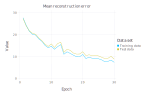

In [21]:
# Train an Softmax0BernoulliRBM for the SNPs as first layer for a DBM 
Random.seed!(1)
monitor1 = Monitor()
snpdata01train, snpdata01test = splitdata(snpdata01, 0.1)
snpdatadict = DataDict("Training data" => snpdata01train, "Test data" => snpdata01test)
snprbm = fitrbm(snpdata01train, categories = 3, upfactor = 2.0, downfactor = 1.0,
      epochs = 30,
      monitoring = (rbm, epoch) ->
            monitorreconstructionerror!(monitor1, rbm, epoch, snpdatadict))
plotevaluation(monitor1)

In [22]:
# Transform the gene expression data into the interval [0,1]: treat them as intensities 
gepintensities = intensities(gepdata);

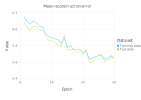

In [23]:
# Train a normal BernoulliRBM with the intensities
monitor2 = Monitor()
gepdatatrain, gepdatatest = splitdata(gepintensities, 0.1)
gepdatadict = DataDict("Training data" => gepdatatrain, "Test data" => gepdatatest)
geprbm = fitrbm(gepintensities, upfactor = 2.0, downfactor = 1.0,
      epochs = 30,
      monitoring = (rbm, epoch) ->
            monitorreconstructionerror!(monitor2, rbm, epoch, gepdatadict))
plotevaluation(monitor2)

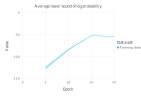

In [24]:
# Train a multimodal DBM with the data that has both SNP and gene expression measurements
jointmonitor = Monitor();
jointdatadict = DataDict("Training data" => combsnpsgeps)
Random.seed!(1)
mdbm = fitdbm(combsnpsgeps,
      pretraining = [
            TrainPartitionedLayer([
               # use the pretrained RBMs in the first layer
               TrainLayer(startrbm = snprbm, epochs = 0);
               TrainLayer(startrbm = geprbm, epochs = 0)]
               );
            TrainLayer(nhidden = 10);
            TrainLayer(nhidden = 2)
      ],
      learningratepretraining = 0.005,
      learningrate = 0.002,
      epochs = 20,
      monitoring = (dbm, epoch) ->
            begin
               if epoch % 5 == 0 # monitor only every few epochs to save some time
                  monitorlogproblowerbound!(jointmonitor, dbm, epoch, jointdatadict)
               end
            end)
plotevaluation(jointmonitor; sdrange = 1.0)

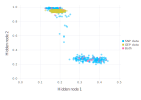

In [25]:
# Estimate the mean hidden activations for the different measurement modalities
# by conditional sampling on a range of variables
function meanhidden(bm::AbstractBM, data::Matrix{Float64},
      range = 1:size(data, 2);
      ngensamples::Int = 500)

   mapreduce(i ->
         begin
            particles = initparticles(bm, size(data, 1))
            particles[1][:, range] .= data
            # Conditional gibbs sampling, return only last hidden layer
            gibbssamplecond!(particles, bm, range)[end]
         end, +, 1:ngensamples) ./ ngensamples
end

# Estimate the mean hidden activations for the different measurement modalities
# and create a scatter plot
snprange = 1:size(snpdata01, 2)
geprange = snprange[end] .+ (1:size(gepdata, 2))
Random.seed!(1);

hidden = vcat(
   meanhidden(mdbm, snpdata01, snprange),
   meanhidden(mdbm, gepintensities, geprange),
   meanhidden(mdbm, combsnpsgeps))

scatterhidden(hidden,
      opacity = 0.5,
      labels = vcat(
            repeat(["SNP data"], size(snpdata01,1)),
            repeat(["GEP data"], size(gepdata,1)),
            repeat(["Both"], size(combsnpsgeps,1))))